In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import nltk
from nltk.util import ngrams
from nltk import pos_tag
from nltk.corpus import stopwords
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoTokenizer
from transformers import XLMRobertaTokenizer, XLMRobertaForCausalLM
import os 

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

In [ ]:
path = os.getcwd() #path should be Evaluation folder
parent = os.path.join(path, os.pardir) #parent directory
memo_dataset_path = os.path.join(parent, "Data/Memo_Dataset.csv")
df = pd.read_csv(memo_dataset_path)
df['Trigger'] = df['Trigger'].astype(int)
min_count = df['Trigger'].value_counts().min()
df= (
    df.groupby('Trigger', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)

In [71]:
LANGUAGE = 'english' #english, arabic, both

In [72]:
if LANGUAGE == 'english':
    df['text'] = df['Question_eng']
elif LANGUAGE == 'arabic':
    df['text'] = df['Question']
else:
    df['text'] = df['Question_eng'] + ' ||| ' + df['Question']

print("Dataset shape:", df.shape)
print("Class distribution:\n", df['Trigger'].value_counts(normalize=True))

Dataset shape: (10910, 4)
Class distribution:
 Trigger
0    0.5
1    0.5
Name: proportion, dtype: float64


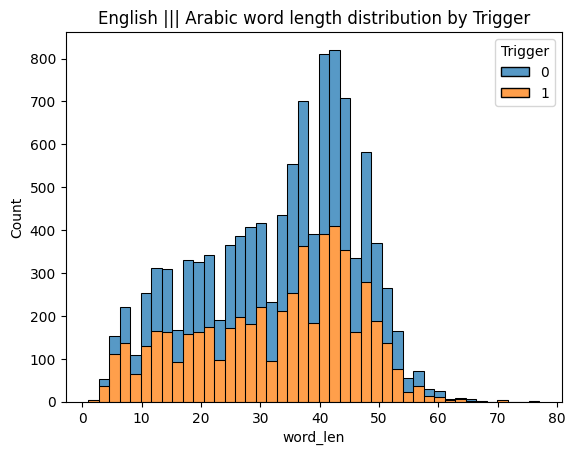

In [30]:
# lengths
df['char_len'] = df['text'].str.len()
df['word_len'] = df['text'].str.split().apply(len)

sns.histplot(df, x='word_len', hue='Trigger', multiple='stack')
plt.title('English ||| Arabic word length distribution by Trigger')
plt.show()

In [73]:
# --- Word count per example ---
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

# Overall stats
print("\nOverall word count statistics:")
print(df['word_count'].describe())

# Per-class stats
print("\nWord count statistics per class:")
class_word_stats = (
    df.groupby('Trigger')['word_count']
      .agg(['count', 'min', 'max', 'mean', 'median', 'std'])
)
print(class_word_stats)



Overall word count statistics:
count    10910.000000
mean        33.236755
std         13.015766
min          1.000000
25%         23.000000
50%         36.000000
75%         43.000000
max         77.000000
Name: word_count, dtype: float64

Word count statistics per class:
         count  min  max       mean  median        std
Trigger                                               
0         5455    3   67  33.777452    36.0  12.564770
1         5455    1   77  32.696059    36.0  13.431051


In [75]:
ahd_path = os.path.join(parent, "Data/AHD_english.xlsx")
ahd_df = pd.read_excel(ahd_path)
ahd_df = ahd_df[['Question', 'Category']]

question_to_category = dict(
    zip(ahd_df['Question'].astype(str), ahd_df['Category'])
)

df['Category'] = df['Question_eng'].astype(str).map(question_to_category)

print("\nMissing category mappings:",
      df['Category'].isna().sum())

df = df.dropna(subset=['Category']) #should be zero



Missing category mappings: 0


In [ ]:
total_samples = len(df)
unique_categories = df['Category'].nunique()
category_counts = df['Category'].value_counts()
category_percentages = df['Category'].value_counts(normalize=True) * 100

print(f"\nTotal samples: {total_samples}")
print(f"Unique health categories: {unique_categories}")
print(f"\nCategory distribution:")
print("-" * 60)

for cat, count in category_counts.items():
    pct = category_percentages[cat]
    print(f"{cat:.<40} {count:>6} ({pct:>5.2f}%)")

print("\n" + "="*80)
print("HEALTH TOPIC DISTRIBUTION BY CLASS")
print("="*80)

# Cross-tabulation
class_category_dist = pd.crosstab(df['Trigger'], df['Category'], margins=True)
class_category_pct = pd.crosstab(df['Trigger'], df['Category'], normalize='index') * 100

print("\n--- Raw Counts ---")
print(class_category_dist)

print("\n--- Percentage within Each Class ---")
print(class_category_pct.round(2))

# Statistical summary by class
for trigger_class in sorted(df['Trigger'].unique()):
    class_data = df[df['Trigger'] == trigger_class]
    print(f"\n--- Class {trigger_class} ---")
    print(f"Total samples: {len(class_data)}")
    print(f"Unique categories: {class_data['Category'].nunique()}")
    print("\nTop 5 categories:")
    top_cats = class_data['Category'].value_counts().head()
    for cat, count in top_cats.items():
        pct = (count / len(class_data)) * 100
        print(f"  {cat}: {count} ({pct:.2f}%)")

plt.figure(figsize=(12, 8))
category_counts_sorted = category_counts.sort_values(ascending=True)
colors = sns.color_palette("husl", len(category_counts_sorted))

plt.barh(range(len(category_counts_sorted)), category_counts_sorted.values, 
         color=colors, edgecolor='black', linewidth=0.5)
plt.yticks(range(len(category_counts_sorted)), category_counts_sorted.index, fontsize=11)
plt.xlabel('Number of Questions', fontsize=13, fontweight='bold')
plt.ylabel('Health Category', fontsize=13, fontweight='bold')
plt.title('Distribution of Health Topics Across Dataset', 
          fontsize=15, fontweight='bold', pad=20)

# Add value labels on bars
for i, v in enumerate(category_counts_sorted.values):
    plt.text(v + max(category_counts_sorted.values)*0.01, i, 
             f'{v} ({v/total_samples*100:.1f}%)', 
             va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
#plt.savefig('health_topics_overall_distribution.png', dpi=300, bbox_inches='tight')
#plt.savefig('health_topics_overall_distribution.pdf', bbox_inches='tight')
#print("\nSaved: health_topics_overall_distribution.png/pdf")
plt.show()

fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data for grouped bar chart
class_category_dist_plot = class_category_dist.drop('All', axis=0).drop('All', axis=1)
x = np.arange(len(class_category_dist_plot.columns))
width = 0.35

# Plot bars for each class
bars1 = ax.bar(x - width/2, class_category_dist_plot.loc[0], width, 
               label='Class 0 (Non-trigger)', color='#1f77b4', 
               edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x + width/2, class_category_dist_plot.loc[1], width, 
               label='Class 1 (Trigger)', color='#f1763d', 
               edgecolor='black', linewidth=0.5)

ax.set_xlabel('Health Category', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Questions', fontsize=13, fontweight='bold')
ax.set_title('Health Topic Distribution by Class', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(class_category_dist_plot.columns, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('health_topics_by_class_grouped.png', dpi=300, bbox_inches='tight')
plt.savefig('health_topics_by_class_grouped.pdf', bbox_inches='tight')
print("Saved: health_topics_by_class_grouped.png/pdf")
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate proportions
class_category_prop = class_category_dist.drop('All', axis=0).drop('All', axis=1)
class_category_prop = class_category_prop.div(class_category_prop.sum(axis=1), axis=0) * 100

# Create stacked bar chart
class_category_prop.T.plot(kind='bar', stacked=True, ax=ax, 
                            color=['#1f77b4', '#f1763d'],
                            edgecolor='black', linewidth=0.5)

ax.set_xlabel('Health Category', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
ax.set_title('Proportional Distribution of Classes within Each Health Topic', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(['Class 0 (Non-trigger)', 'Class 1 (Trigger)'], 
          fontsize=11, loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
#plt.savefig('health_topics_class_proportions.png', dpi=300, bbox_inches='tight')
#plt.savefig('health_topics_class_proportions.pdf', bbox_inches='tight')
#print("Saved: health_topics_class_proportions.png/pdf")
plt.show()

plt.figure(figsize=(12, 6))

# Prepare data (without margins)
heatmap_data = class_category_dist.drop('All', axis=0).drop('All', axis=1).T

sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Questions'}, 
            linewidths=1, linecolor='white',
            xticklabels=['Class 0 (Non-trigger)', 'Class 1 (Trigger)'])

plt.xlabel('Class', fontsize=13, fontweight='bold')
plt.ylabel('Health Category', fontsize=13, fontweight='bold')
plt.title('Heatmap: Health Topic Counts Across Classes', 
          fontsize=15, fontweight='bold', pad=20)
plt.yticks(rotation=0, fontsize=10)
plt.xticks(fontsize=11)

plt.tight_layout()
#plt.savefig('health_topics_heatmap_counts.png', dpi=300, bbox_inches='tight')
#plt.savefig('health_topics_heatmap_counts.pdf', bbox_inches='tight')
#print("Saved: health_topics_heatmap_counts.png/pdf")
plt.show()

plt.figure(figsize=(12, 6))

# Prepare percentage data
heatmap_pct_data = class_category_pct.drop('All', axis=0).T

sns.heatmap(heatmap_pct_data, annot=True, fmt='.1f', cmap='coolwarm', 
            cbar_kws={'label': 'Percentage (%)'}, 
            linewidths=1, linecolor='white',
            xticklabels=['Class 0 (Non-trigger)', 'Class 1 (Trigger)'])

plt.xlabel('Class', fontsize=13, fontweight='bold')
plt.ylabel('Health Category', fontsize=13, fontweight='bold')
plt.title('Heatmap: Health Topic Distribution (% within each class)', 
          fontsize=15, fontweight='bold', pad=20)
plt.yticks(rotation=0, fontsize=10)
plt.xticks(fontsize=11)

plt.tight_layout()
#plt.savefig('health_topics_heatmap_percentages.png', dpi=300, bbox_inches='tight')
#plt.savefig('health_topics_heatmap_percentages.pdf', bbox_inches='tight')
#print("Saved: health_topics_heatmap_percentages.png/pdf")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Overall distribution
colors_pie = sns.color_palette("husl", len(category_counts))
wedges, texts, autotexts = axes[0].pie(category_counts.values, 
                                         labels=category_counts.index,
                                         autopct='%1.1f%%', 
                                         colors=colors_pie, 
                                         startangle=90)
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)
axes[0].set_title('Overall Distribution', fontsize=13, fontweight='bold', pad=15)

# Class 0 distribution
class0_counts = df[df['Trigger'] == 0]['Category'].value_counts()
wedges, texts, autotexts = axes[1].pie(class0_counts.values, 
                                         labels=class0_counts.index,
                                         autopct='%1.1f%%', 
                                         colors=colors_pie[:len(class0_counts)], 
                                         startangle=90)
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)
axes[1].set_title('Class 0 (Non-trigger)', fontsize=13, fontweight='bold', pad=15)

# Class 1 distribution
class1_counts = df[df['Trigger'] == 1]['Category'].value_counts()
wedges, texts, autotexts = axes[2].pie(class1_counts.values, 
                                         labels=class1_counts.index,
                                         autopct='%1.1f%%', 
                                         colors=colors_pie[:len(class1_counts)], 
                                         startangle=90)
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)
axes[2].set_title('Class 1 (Trigger)', fontsize=13, fontweight='bold', pad=15)

plt.suptitle('Health Topic Distribution: Overall and by Class', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
#plt.savefig('health_topics_pie_charts.png', dpi=300, bbox_inches='tight')
#plt.savefig('health_topics_pie_charts.pdf', bbox_inches='tight')
#print("Saved: health_topics_pie_charts.png/pdf")
plt.show()

print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)

summary_table = pd.DataFrame({
    'Health Category': category_counts.index,
    'Total': category_counts.values,
    'Total (%)': category_percentages.values,
    'Class 0': [class_category_dist.loc[0, cat] for cat in category_counts.index],
    'Class 0 (%)': [class_category_pct.loc[0, cat] for cat in category_counts.index],
    'Class 1': [class_category_dist.loc[1, cat] for cat in category_counts.index],
    'Class 1 (%)': [class_category_pct.loc[1, cat] for cat in category_counts.index],
})

totals_row = pd.DataFrame({
    'Health Category': ['Total'],
    'Total': [total_samples],
    'Total (%)': [100.0],
    'Class 0': [min_count],
    'Class 0 (%)': [100.0],
    'Class 1': [min_count],
    'Class 1 (%)': [100.0]
})

summary_table = pd.concat([summary_table, totals_row], ignore_index=True)
for col in ['Total (%)', 'Class 0 (%)', 'Class 1 (%)']:
    summary_table[col] = summary_table[col].apply(lambda x: f"{x:.2f}")

print("\n", summary_table.to_string(index=False))

summary_table.to_csv('health_topics_distribution_table.csv', index=False)
summary_table.to_latex('health_topics_distribution_table.tex', index=False)
print("\nSaved: health_topics_distribution_table.csv")
print("Saved: health_topics_distribution_table.tex")


Generating publication-ready visualizations for 65 categories...

Saved: health_topics_top15_categories.png/pdf


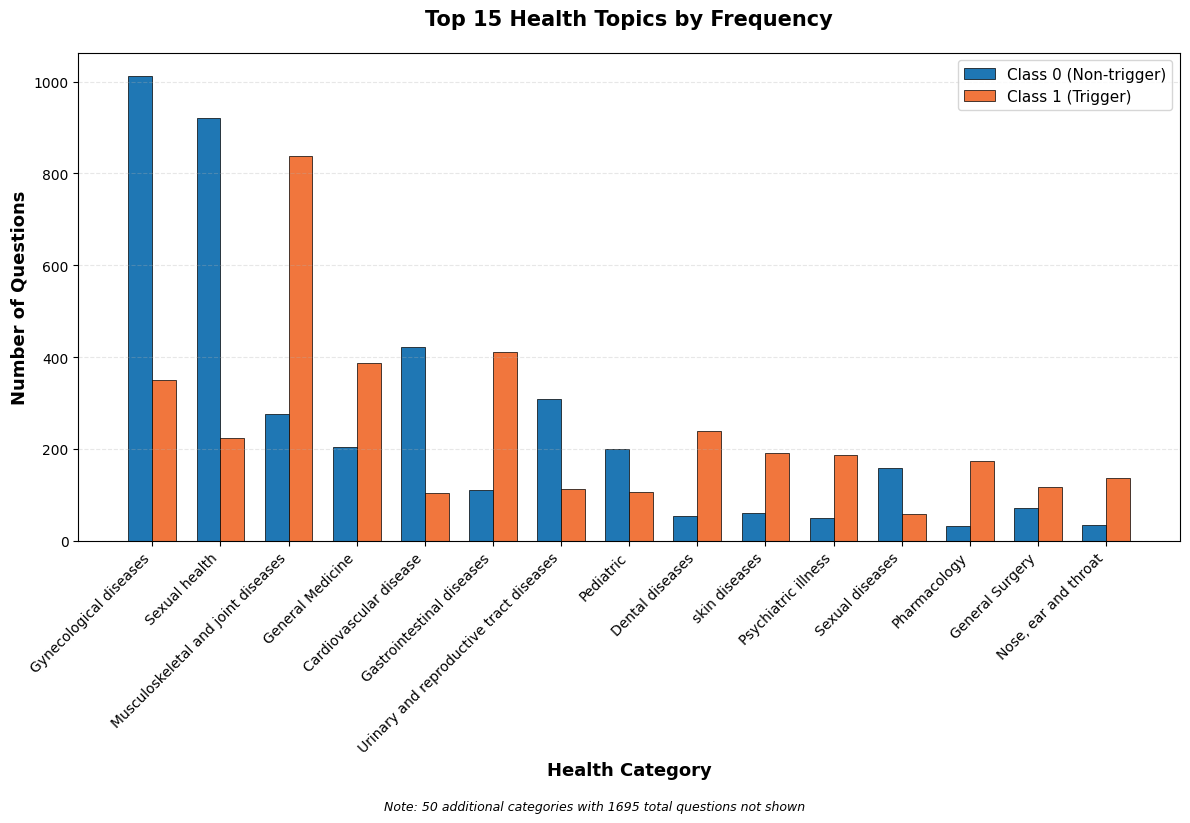

Saved: health_topics_category_analysis.png/pdf


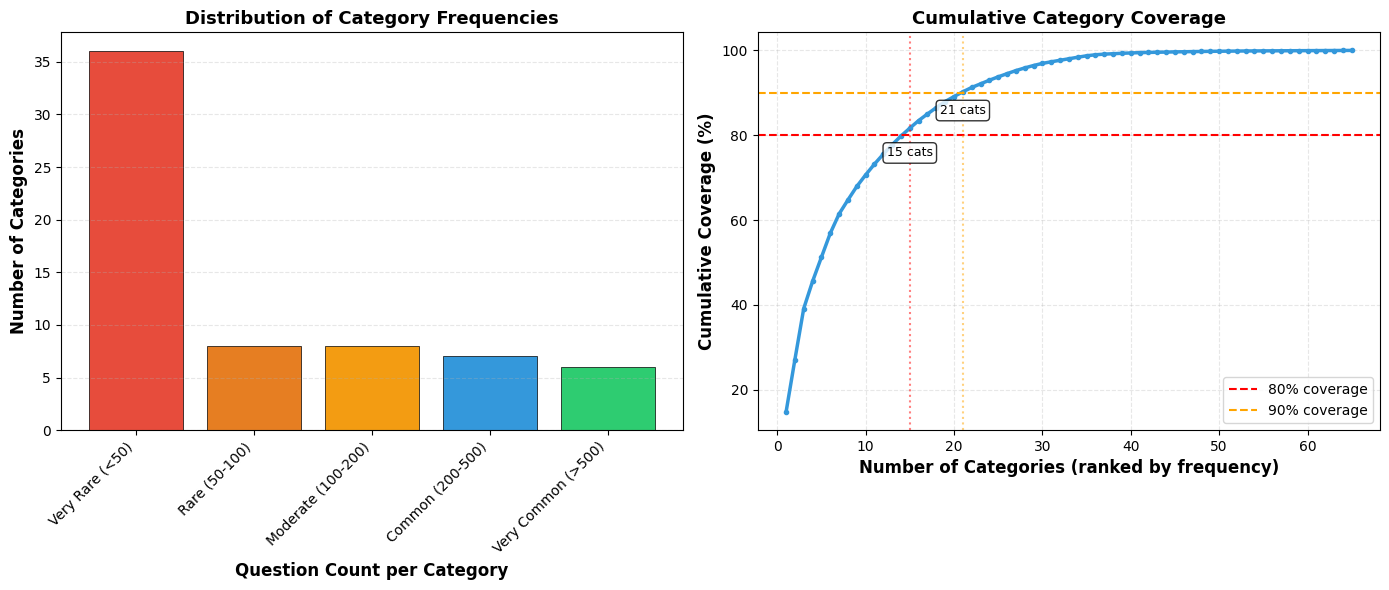


Top 15 categories cover 80% of the dataset
Top 21 categories cover 90% of the dataset
Saved: health_topics_heatmap_top20.png/pdf


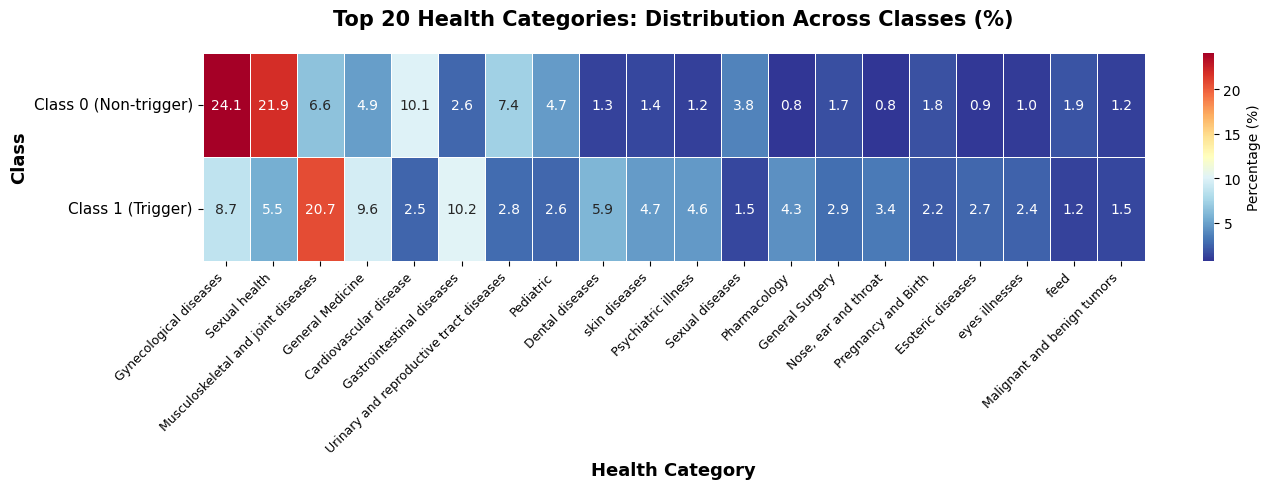

Saved: health_topics_summary_statistics.png/pdf


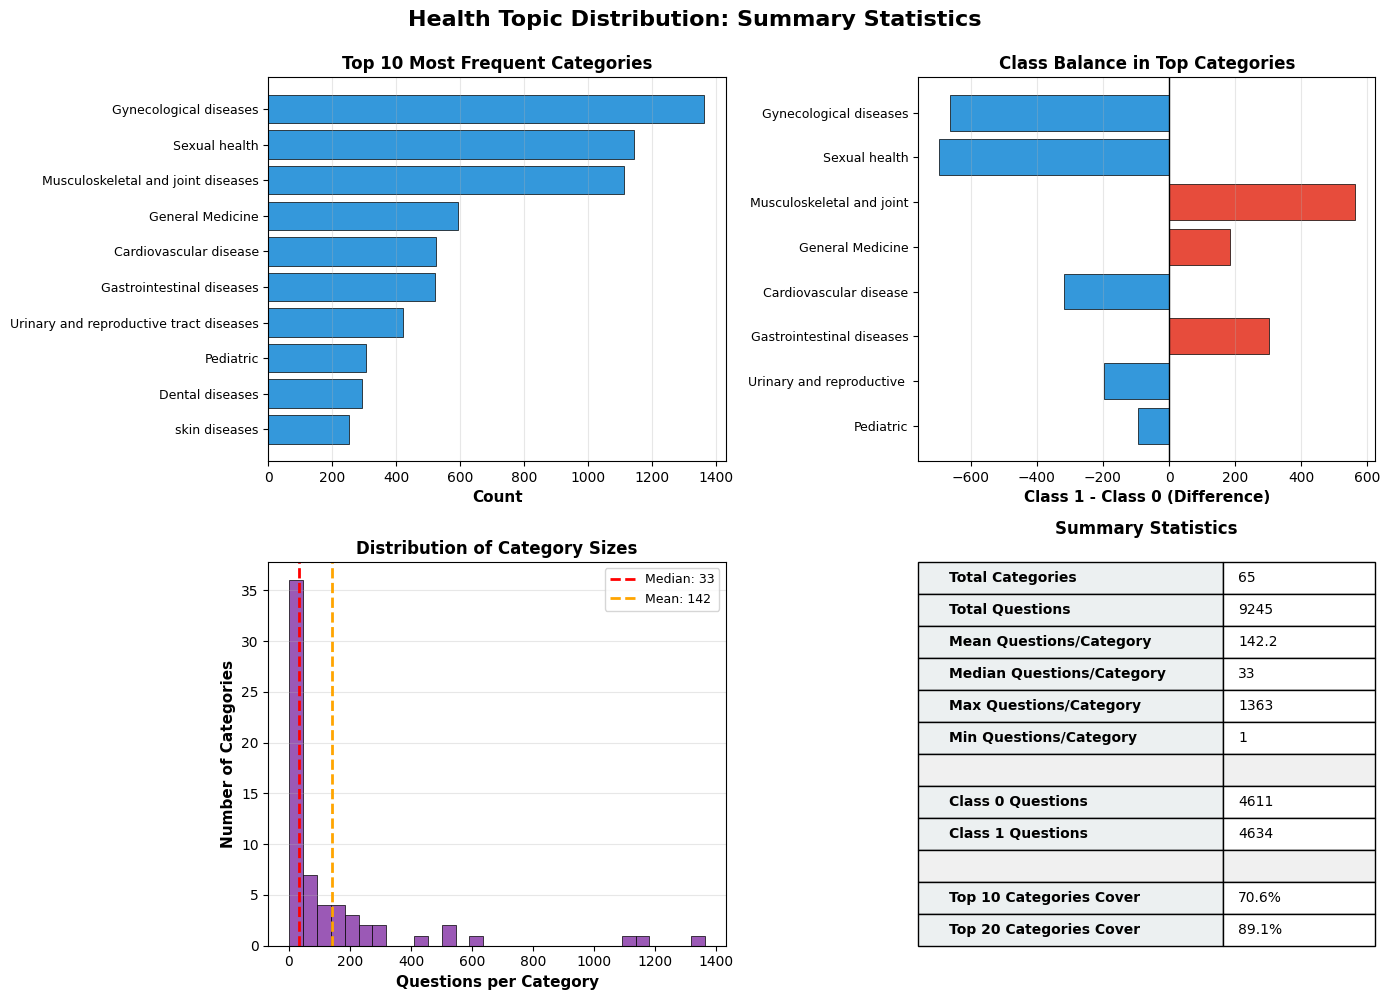

In [77]:
def plot_top_k_categories(df, k=15):
    """Plot top K most frequent health categories"""
    
    # Get top K categories
    top_categories = df['Category'].value_counts().head(k)
    
    # Get counts by class for these categories
    top_cat_names = top_categories.index
    class0_counts = []
    class1_counts = []
    
    for cat in top_cat_names:
        class0_counts.append(len(df[(df['Category'] == cat) & (df['Trigger'] == 0)]))
        class1_counts.append(len(df[(df['Category'] == cat) & (df['Trigger'] == 1)]))
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(top_cat_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, class0_counts, width, 
                   label='Class 0 (Non-trigger)', color='#1f77b4', 
                   edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, class1_counts, width, 
                   label='Class 1 (Trigger)', color='#f1763d', 
                   edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Health Category', fontsize=13, fontweight='bold')
    ax.set_ylabel('Number of Questions', fontsize=13, fontweight='bold')
    ax.set_title(f'Top {k} Health Topics by Frequency', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(top_cat_names, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add note about remaining categories
    remaining_cats = df['Category'].nunique() - k
    total_in_others = len(df[~df['Category'].isin(top_cat_names)])
    note_text = f'Note: {remaining_cats} additional categories with {total_in_others} total questions not shown'
    plt.figtext(0.5, -0.02, note_text, ha='center', fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.savefig(f'health_topics_top{k}_categories.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'health_topics_top{k}_categories.pdf', bbox_inches='tight')
    print(f"Saved: health_topics_top{k}_categories.png/pdf")
    plt.show()

def plot_category_groups(df):
    """Group categories into broader themes for cleaner visualization"""
    
    # Calculate diversity metrics
    category_counts = df['Category'].value_counts()
    
    # Bin categories by frequency
    bins = [0, 50, 100, 200, 500, float('inf')]
    labels = ['Very Rare (<50)', 'Rare (50-100)', 'Moderate (100-200)', 
              'Common (200-500)', 'Very Common (>500)']
    
    frequency_distribution = pd.cut(category_counts.values, bins=bins, labels=labels).value_counts()
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: Frequency distribution of categories
    colors_freq = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#2ecc71']
    ax1.bar(range(len(frequency_distribution)), frequency_distribution.values, 
            color=colors_freq, edgecolor='black', linewidth=0.5)
    ax1.set_xticks(range(len(frequency_distribution)))
    ax1.set_xticklabels(frequency_distribution.index, rotation=45, ha='right')
    ax1.set_ylabel('Number of Categories', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Question Count per Category', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution of Category Frequencies', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Right: Cumulative coverage
    sorted_counts = category_counts.sort_values(ascending=False)
    cumulative_pct = (sorted_counts.cumsum() / sorted_counts.sum() * 100).values
    
    ax2.plot(range(1, len(cumulative_pct)+1), cumulative_pct, 
             linewidth=2.5, color='#3498db', marker='o', markersize=3)
    ax2.axhline(y=80, color='red', linestyle='--', linewidth=1.5, label='80% coverage')
    ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1.5, label='90% coverage')
    
    # Find how many categories needed for 80% and 90%
    cats_80 = np.argmax(cumulative_pct >= 80) + 1
    cats_90 = np.argmax(cumulative_pct >= 90) + 1
    
    ax2.axvline(x=cats_80, color='red', linestyle=':', alpha=0.5)
    ax2.axvline(x=cats_90, color='orange', linestyle=':', alpha=0.5)
    
    ax2.text(cats_80, 75, f'{cats_80} cats', ha='center', fontsize=9, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax2.text(cats_90, 85, f'{cats_90} cats', ha='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax2.set_xlabel('Number of Categories (ranked by frequency)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Cumulative Coverage (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Cumulative Category Coverage', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('health_topics_category_analysis.png', dpi=300, bbox_inches='tight')
    plt.savefig('health_topics_category_analysis.pdf', bbox_inches='tight')
    print("Saved: health_topics_category_analysis.png/pdf")
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"Top {cats_80} categories cover 80% of the dataset")
    print(f"Top {cats_90} categories cover 90% of the dataset")
    print(f"{'='*60}")

def plot_compact_heatmap(df, top_k=20):
    """Heatmap showing only top K categories"""
    
    top_categories = df['Category'].value_counts().head(top_k).index
    df_top = df[df['Category'].isin(top_categories)]
    
    class_category_dist = pd.crosstab(df_top['Trigger'], df_top['Category'])
    class_category_pct = pd.crosstab(df_top['Trigger'], df_top['Category'], 
                                     normalize='index') * 100
    
    # Sort by total frequency
    col_order = class_category_dist.sum(axis=0).sort_values(ascending=False).index
    class_category_pct = class_category_pct[col_order]
    
    plt.figure(figsize=(14, 5))
    
    sns.heatmap(class_category_pct, annot=True, fmt='.1f', cmap='RdYlBu_r', 
                cbar_kws={'label': 'Percentage (%)'}, 
                linewidths=0.5, linecolor='white',
                yticklabels=['Class 0 (Non-trigger)', 'Class 1 (Trigger)'])
    
    plt.xlabel('Health Category', fontsize=13, fontweight='bold')
    plt.ylabel('Class', fontsize=13, fontweight='bold')
    plt.title(f'Top {top_k} Health Categories: Distribution Across Classes (%)', 
              fontsize=15, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f'health_topics_heatmap_top{top_k}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'health_topics_heatmap_top{top_k}.pdf', bbox_inches='tight')
    print(f"Saved: health_topics_heatmap_top{top_k}.png/pdf")
    plt.show()

def create_summary_statistics(df):
    """Create a clean summary statistics visualization"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Health Topic Distribution: Summary Statistics', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # 1. Overall category distribution (top 10)
    ax1 = axes[0, 0]
    top10 = df['Category'].value_counts().head(10)
    ax1.barh(range(len(top10)), top10.values, color='#3498db', edgecolor='black', linewidth=0.5)
    ax1.set_yticks(range(len(top10)))
    ax1.set_yticklabels(top10.index, fontsize=9)
    ax1.set_xlabel('Count', fontsize=11, fontweight='bold')
    ax1.set_title('Top 10 Most Frequent Categories', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Class comparison for top categories
    ax2 = axes[0, 1]
    top_cats = df['Category'].value_counts().head(8).index
    class_diff = []
    cat_labels = []
    
    for cat in top_cats:
        c0 = len(df[(df['Category'] == cat) & (df['Trigger'] == 0)])
        c1 = len(df[(df['Category'] == cat) & (df['Trigger'] == 1)])
        diff = c1 - c0  # Positive means more in Class 1
        class_diff.append(diff)
        cat_labels.append(cat[:25])  # Truncate long names
    
    colors = ['#e74c3c' if d > 0 else '#3498db' for d in class_diff]
    ax2.barh(range(len(class_diff)), class_diff, color=colors, edgecolor='black', linewidth=0.5)
    ax2.set_yticks(range(len(cat_labels)))
    ax2.set_yticklabels(cat_labels, fontsize=9)
    ax2.set_xlabel('Class 1 - Class 0 (Difference)', fontsize=11, fontweight='bold')
    ax2.set_title('Class Balance in Top Categories', fontsize=12, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Category size distribution
    ax3 = axes[1, 0]
    category_sizes = df['Category'].value_counts().values
    ax3.hist(category_sizes, bins=30, color='#9b59b6', edgecolor='black', linewidth=0.5)
    ax3.set_xlabel('Questions per Category', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Number of Categories', fontsize=11, fontweight='bold')
    ax3.set_title('Distribution of Category Sizes', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add statistics text
    median_size = np.median(category_sizes)
    mean_size = np.mean(category_sizes)
    ax3.axvline(median_size, color='red', linestyle='--', linewidth=2, label=f'Median: {median_size:.0f}')
    ax3.axvline(mean_size, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_size:.0f}')
    ax3.legend(fontsize=9)
    
    # 4. Key statistics table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    stats_data = [
        ['Total Categories', f'{df["Category"].nunique()}'],
        ['Total Questions', f'{len(df)}'],
        ['Mean Questions/Category', f'{len(df)/df["Category"].nunique():.1f}'],
        ['Median Questions/Category', f'{np.median(category_sizes):.0f}'],
        ['Max Questions/Category', f'{category_sizes.max()}'],
        ['Min Questions/Category', f'{category_sizes.min()}'],
        ['', ''],
        ['Class 0 Questions', f'{len(df[df["Trigger"]==0])}'],
        ['Class 1 Questions', f'{len(df[df["Trigger"]==1])}'],
        ['', ''],
        ['Top 10 Categories Cover', f'{df["Category"].value_counts().head(10).sum()/len(df)*100:.1f}%'],
        ['Top 20 Categories Cover', f'{df["Category"].value_counts().head(20).sum()/len(df)*100:.1f}%'],
    ]
    
    table = ax4.table(cellText=stats_data, cellLoc='left',
                      colWidths=[0.6, 0.3], loc='center',
                      bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    for i in range(len(stats_data)):
        if stats_data[i][0] == '':
            table[(i, 0)].set_facecolor('#f0f0f0')
            table[(i, 1)].set_facecolor('#f0f0f0')
        else:
            table[(i, 0)].set_facecolor('#ecf0f1')
            table[(i, 1)].set_facecolor('white')
        table[(i, 0)].set_text_props(weight='bold')
    
    ax4.set_title('Summary Statistics', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('health_topics_summary_statistics.png', dpi=300, bbox_inches='tight')
    plt.savefig('health_topics_summary_statistics.pdf', bbox_inches='tight')
    print("Saved: health_topics_summary_statistics.png/pdf")
    plt.show()

print("\nGenerating publication-ready visualizations for 65 categories...\n")

# Generate all recommended plots
plot_top_k_categories(df, k=15)  # Top 15 categories
plot_category_groups(df)  # Category frequency analysis
plot_compact_heatmap(df, top_k=20)  # Heatmap of top 20
create_summary_statistics(df)  # 4-panel summary

Generating visualizations with custom colors...

Saved: health_topics_class_differences_clean.png/pdf


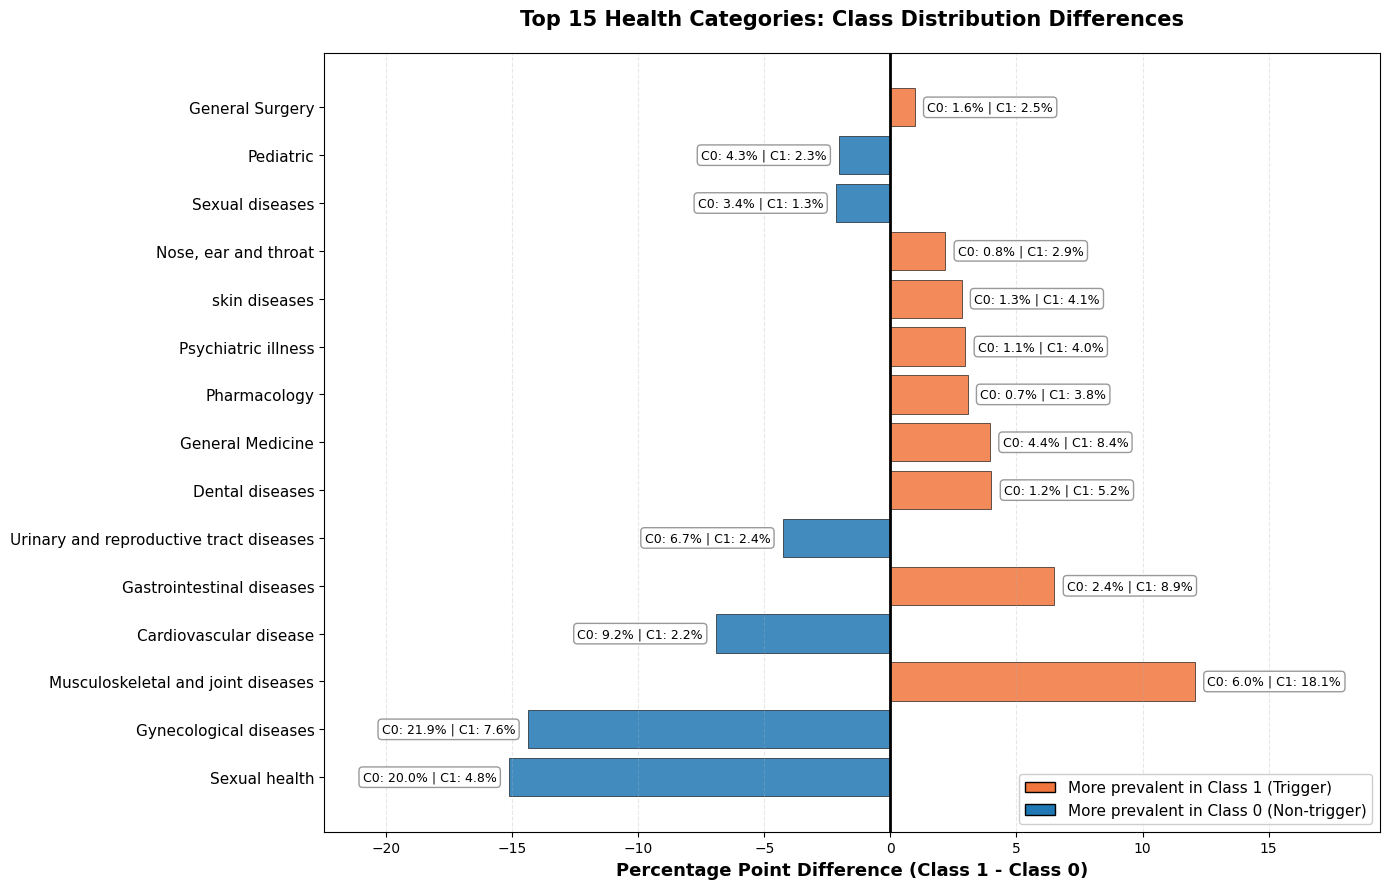

In [82]:
def plot_class_difference_top_categories_clean(df, top_k=15):
    """
    Cleaner version with better label placement and custom colors
    """
    # Custom colors
    TRIGGER_COLOR = '#f1763d'      # Class 1 (Trigger)
    NON_TRIGGER_COLOR = '#1f77b4'  # Class 0 (Non-trigger)
    
    top_categories = df['Category'].value_counts().head(top_k).index
    
    differences = []
    cat_names = []
    class0_pcts = []
    class1_pcts = []
    
    for cat in top_categories:
        c0_pct = len(df[(df['Category'] == cat) & (df['Trigger'] == 0)]) / len(df[df['Trigger'] == 0]) * 100
        c1_pct = len(df[(df['Category'] == cat) & (df['Trigger'] == 1)]) / len(df[df['Trigger'] == 1]) * 100
        
        differences.append(c1_pct - c0_pct)
        cat_names.append(cat)
        class0_pcts.append(c0_pct)
        class1_pcts.append(c1_pct)
    
    # Sort by absolute difference
    sorted_indices = np.argsort([abs(d) for d in differences])[::-1]
    
    fig, ax = plt.subplots(figsize=(14, 9))
    
    y_pos = np.arange(len(sorted_indices))
    sorted_diffs = [differences[i] for i in sorted_indices]
    sorted_names = [cat_names[i] for i in sorted_indices]
    
    colors = [TRIGGER_COLOR if d > 0 else NON_TRIGGER_COLOR for d in sorted_diffs]
    
    bars = ax.barh(y_pos, sorted_diffs, color=colors, edgecolor='black', linewidth=0.5, alpha=0.85)
    
    # Improved label placement - ALWAYS outside to avoid overlap
    for i, (bar, diff, idx) in enumerate(zip(bars, sorted_diffs, sorted_indices)):
        c0 = class0_pcts[idx]
        c1 = class1_pcts[idx]
        
        # Always place labels outside bars
        if diff > 0:
            x_pos = diff + 0.5
            ha = 'left'
        else:
            x_pos = diff - 0.5
            ha = 'right'
        
        ax.text(x_pos, i, f'C0: {c0:.1f}% | C1: {c1:.1f}%', 
                va='center', ha=ha, fontsize=9, color='black', weight='normal',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_names, fontsize=11)
    ax.set_xlabel('Percentage Point Difference (Class 1 - Class 0)', fontsize=13, fontweight='bold')
    ax.set_title(f'Top {top_k} Health Categories: Class Distribution Differences', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add legend with custom colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=TRIGGER_COLOR, edgecolor='black', label='More prevalent in Class 1 (Trigger)'),
        Patch(facecolor=NON_TRIGGER_COLOR, edgecolor='black', label='More prevalent in Class 0 (Non-trigger)')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.95)
    
    # Add more padding to x-axis to prevent label cutoff
    x_min, x_max = ax.get_xlim()
    padding = (x_max - x_min) * 0.2
    ax.set_xlim(x_min - padding, x_max + padding)
    
    plt.tight_layout()
    plt.savefig('health_topics_class_differences_clean.png', dpi=300, bbox_inches='tight')
    plt.savefig('health_topics_class_differences_clean.pdf', bbox_inches='tight')
    print("Saved: health_topics_class_differences_clean.png/pdf")
    plt.show()


# Run all three versions with fixes
print("Generating visualizations with custom colors...\n")
plot_class_difference_top_categories_clean(df, top_k=15)

Top 1-grams overall:
[('pain', np.int64(3530)), ('old', np.int64(1980)), ('years', np.int64(1687)), ('feel', np.int64(1639)), ('suffer', np.int64(1572)), ('normal', np.int64(1468)), ('days', np.int64(1336)), ('doctor', np.int64(1289)), ('does', np.int64(1247)), ('blood', np.int64(1232)), ('peace', np.int64(1090)), ('months', np.int64(1066)), ('period', np.int64(1050)), ('left', np.int64(968)), ('treatment', np.int64(921)), ('ago', np.int64(905)), ('time', np.int64(862)), ('month', np.int64(859)), ('day', np.int64(838)), ('did', np.int64(801))]
Top 1-grams for triggers:
[('pain', np.int64(2237)), ('suffer', np.int64(933)), ('feel', np.int64(878)), ('old', np.int64(827)), ('years', np.int64(789)), ('doctor', np.int64(639)), ('treatment', np.int64(583)), ('does', np.int64(556)), ('blood', np.int64(556)), ('days', np.int64(555)), ('severe', np.int64(543)), ('peace', np.int64(497)), ('left', np.int64(496)), ('months', np.int64(495)), ('ago', np.int64(461)), ('time', np.int64(447)), ('right'

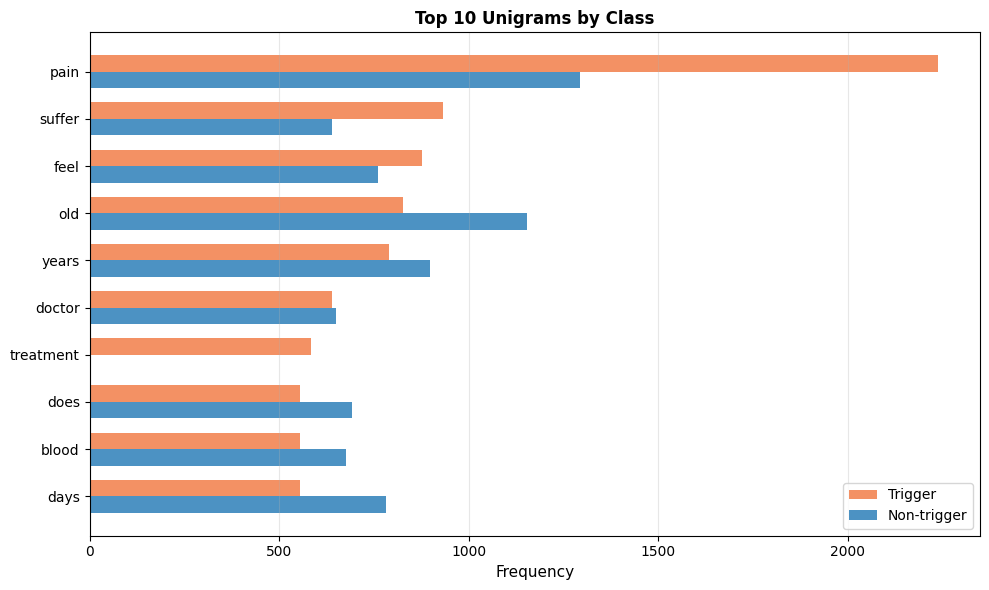

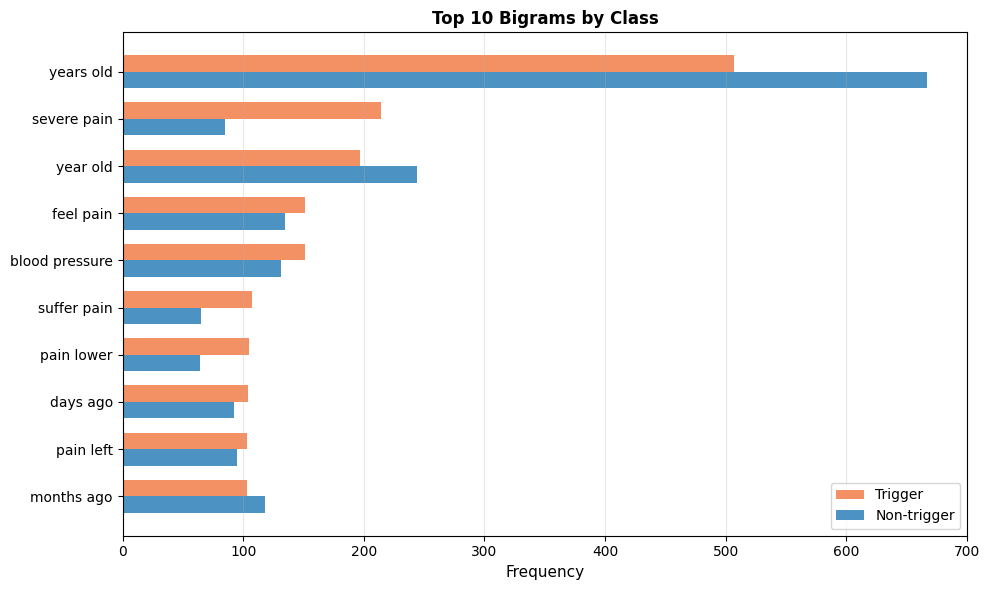

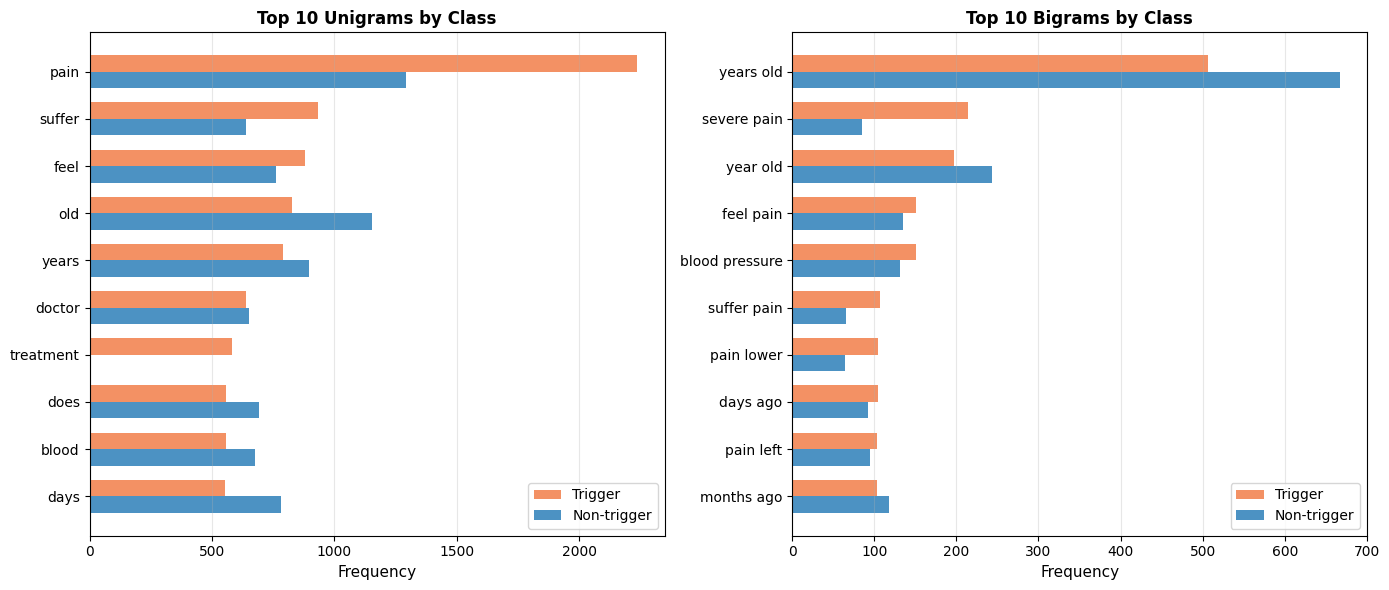

In [31]:
def get_top_ngrams(texts, n=1, top_k=20): #ngram analysis
    vec = CountVectorizer(ngram_range=(n,n), stop_words='english' if LANGUAGE in ['english','both'] else None)
    X = vec.fit_transform(texts)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

trigger_texts = df[df['Trigger']==1]['text']
non_trigger_texts = df[df['Trigger']==0]['text']

ngram_data = {}
for n in [1,2,3]:
    print(f"Top {n}-grams overall:")
    overall = get_top_ngrams(df['text'], n)
    print(overall)
    
    print(f"Top {n}-grams for triggers:")
    triggers = get_top_ngrams(trigger_texts, n)
    print(triggers)
    
    print(f"Top {n}-grams for non-triggers:")
    non_triggers = get_top_ngrams(non_trigger_texts, n)
    print(non_triggers)
    
    # Store for plotting
    ngram_data[n] = {
        'triggers': triggers,
        'non_triggers': non_triggers
    }


def plot_ngram_comparison(trigger_ngrams, nontrigger_ngrams, n, top_k=20, save_path=None):
    #horizontal bar chart comparing trigger vs non-trigger n-grams
    top_trigger = trigger_ngrams[:top_k]
    trigger_words = [w for w, _ in top_trigger]
    trigger_counts = [c for _, c in top_trigger]
    
    #counts for the same words from non-triggers
    nontrigger_dict = dict(nontrigger_ngrams)
    nontrigger_counts = [nontrigger_dict.get(w, 0) for w in trigger_words]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(trigger_words))
    width = 0.35
    
    bars1 = ax.barh(x - width/2, trigger_counts, width, 
                    label='Trigger', color='#f1763d', alpha=0.8)
    bars2 = ax.barh(x + width/2, nontrigger_counts, width, 
                    label='Non-trigger', color='#1f77b4', alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(trigger_words)
    ax.set_xlabel('Frequency', fontsize=11)
    
    ngram_name = {1: 'Unigrams', 2: 'Bigrams', 3: 'Trigrams'}
    ax.set_title(f'Top {top_k} {ngram_name[n]} by Class', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    return fig

#individual plots for 1-grams and 2-grams
fig1 = plot_ngram_comparison(
    ngram_data[1]['triggers'], 
    ngram_data[1]['non_triggers'], 
    n=1, 
    top_k=10,
    save_path='unigram_comparison.png'
)

fig2 = plot_ngram_comparison(
    ngram_data[2]['triggers'], 
    ngram_data[2]['non_triggers'], 
    n=2, 
    top_k=10,
    save_path='bigram_comparison.png'
)

#combined plot with both 1-grams and 2-grams side by side
def plot_combined_ngrams(ngram_data, top_k=20, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for idx, n in enumerate([1, 2]):
        ax = axes[idx]
        
        # Get data
        top_trigger = ngram_data[n]['triggers'][:top_k]
        trigger_words = [w for w, _ in top_trigger]
        trigger_counts = [c for _, c in top_trigger]
        
        nontrigger_dict = dict(ngram_data[n]['non_triggers'])
        nontrigger_counts = [nontrigger_dict.get(w, 0) for w in trigger_words]
        
        # Plot
        x = np.arange(len(trigger_words))
        width = 0.35
        
        bars1 = ax.barh(x - width/2, trigger_counts, width, 
                        label='Trigger', color='#f1763d', alpha=0.8)
        bars2 = ax.barh(x + width/2, nontrigger_counts, width, 
                        label='Non-trigger', color='#1f77b4', alpha=0.8)
        
        ax.set_yticks(x)
        ax.set_yticklabels(trigger_words)
        ax.set_xlabel('Frequency', fontsize=11)
        
        ngram_name = {1: 'Unigrams', 2: 'Bigrams'}
        ax.set_title(f'Top {top_k} {ngram_name[n]} by Class', 
                     fontsize=12, fontweight='bold')
        ax.legend(loc='lower right')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved combined plot to {save_path}")
    
    return fig

# Create combined plot
fig_combined = plot_combined_ngrams(
    ngram_data, 
    top_k=10, 
    save_path='ngram_comparison_combined.png'
)

plt.show()


Saved trigger plot to unigram_1gram_trigger.png
Saved non-trigger plot to unigram_1gram_nontrigger.png
Saved trigger plot to bigram_2gram_trigger.png
Saved non-trigger plot to bigram_2gram_nontrigger.png
Saved trigger plot to trigram_3gram_trigger.png
Saved non-trigger plot to trigram_3gram_nontrigger.png


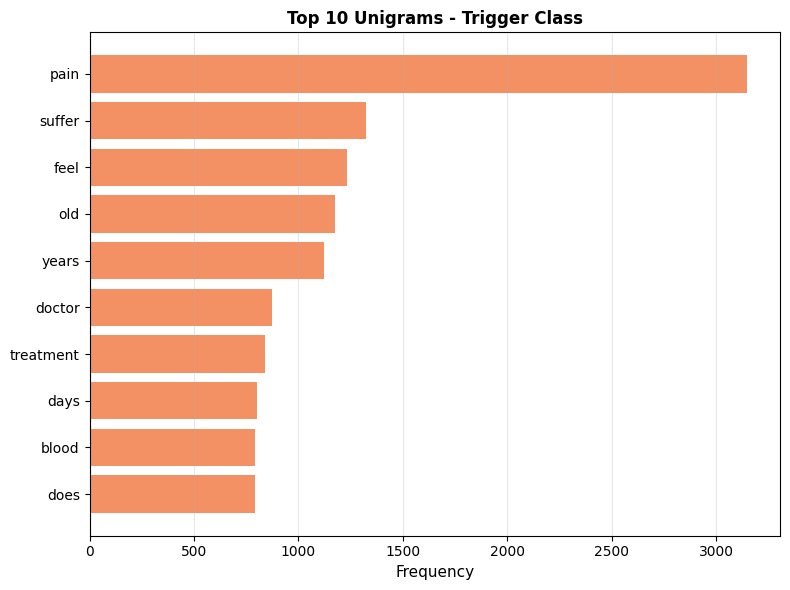

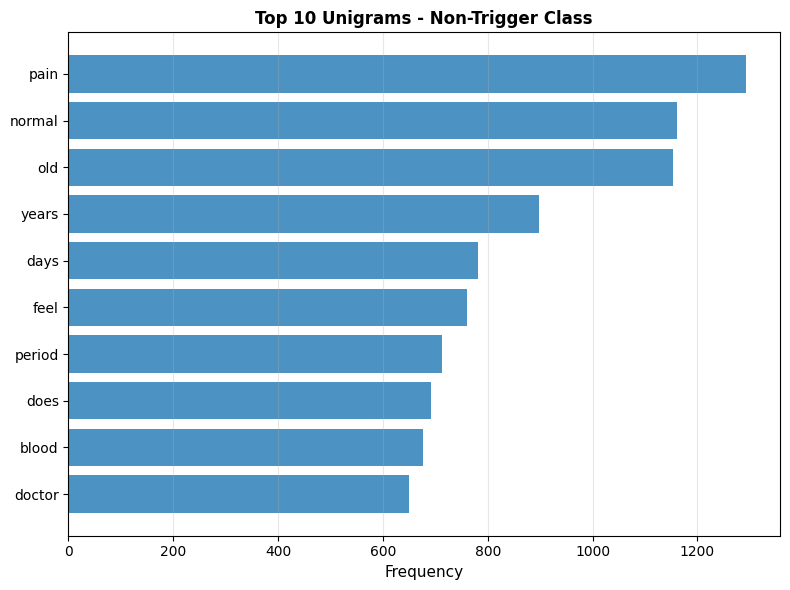

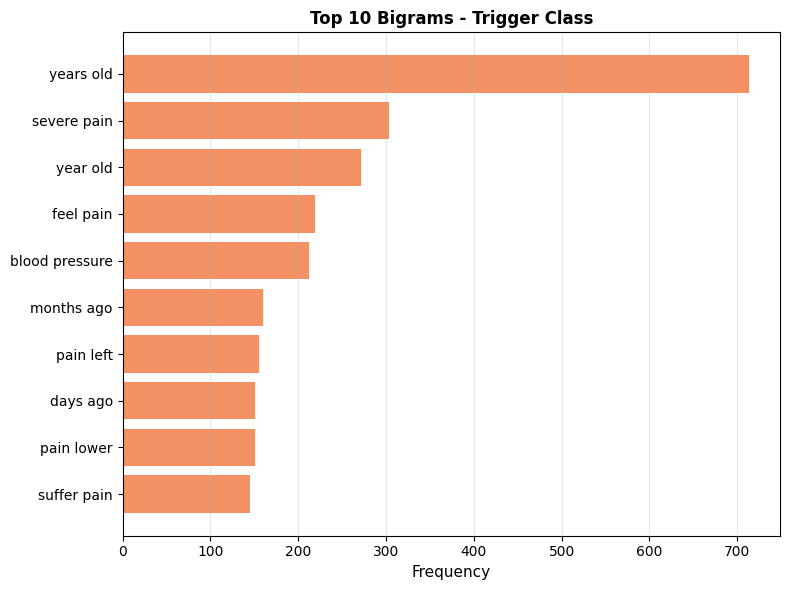

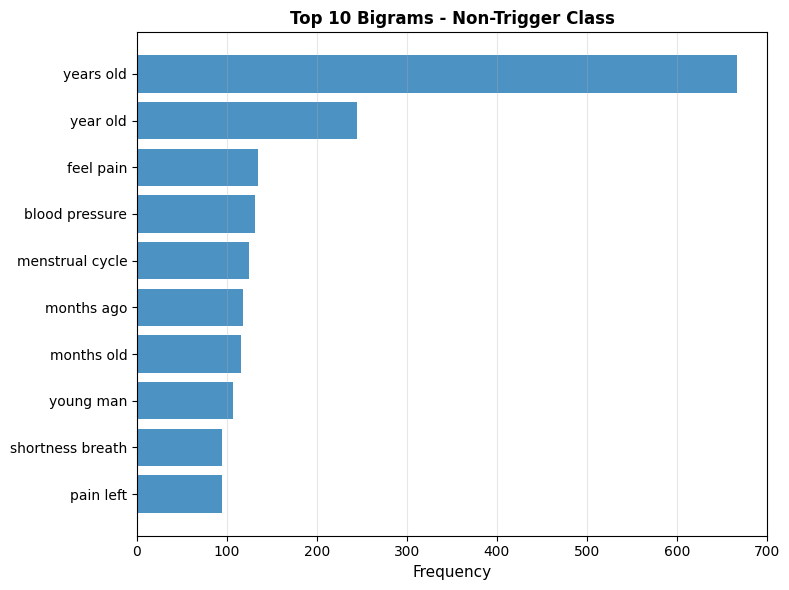

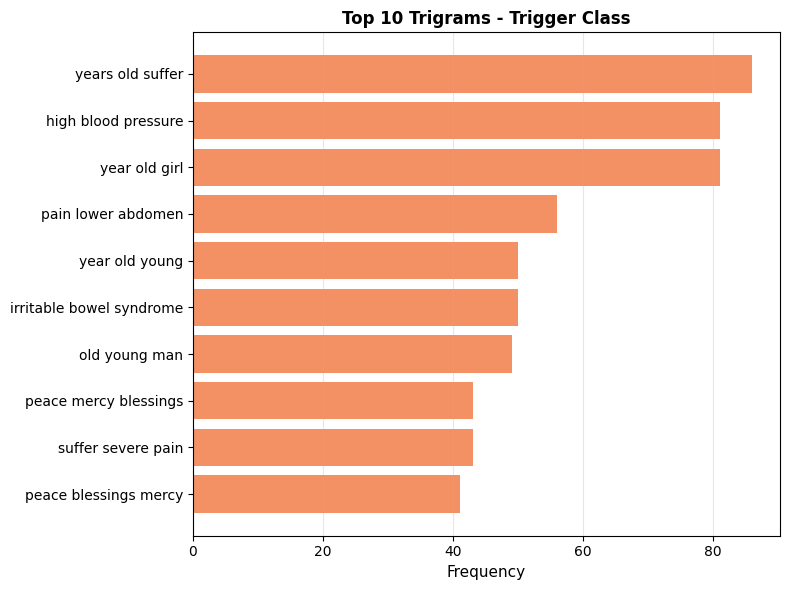

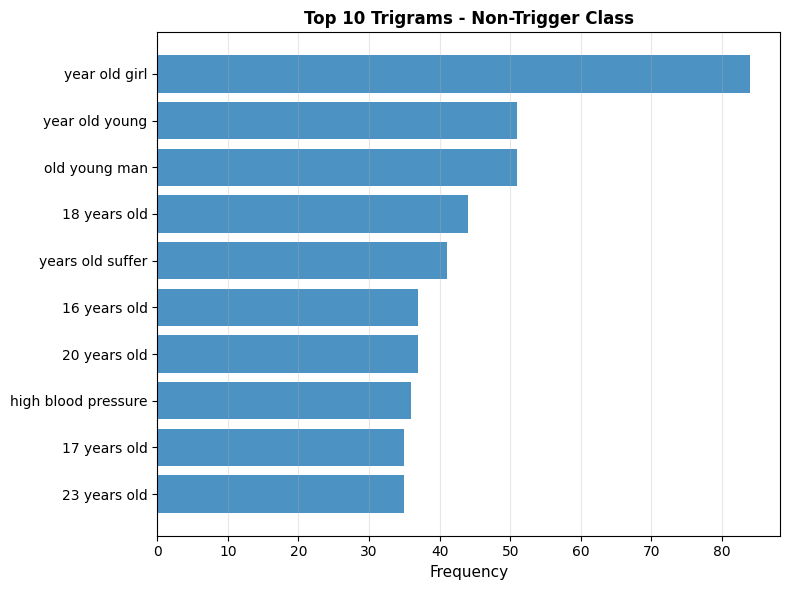

In [22]:
def plot_ngrams_by_class(trigger_ngrams, nontrigger_ngrams, n, top_k=10, save_prefix='ngrams'):
    #separate horizontal bar charts for trigger and non-trigger classes
    ngram_name = {1: 'Unigrams', 2: 'Bigrams', 3: 'Trigrams'}
    
    #Trigger class
    fig1, ax1 = plt.subplots(figsize=(8, 6))
    
    top_trigger = trigger_ngrams[:top_k]
    trigger_words = [w for w, _ in top_trigger]
    trigger_counts = [c for _, c in top_trigger]
    
    y_pos = np.arange(len(trigger_words))
    bars1 = ax1.barh(y_pos, trigger_counts, color='#f1763d', alpha=0.8)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(trigger_words)
    ax1.set_xlabel('Frequency', fontsize=11)
    ax1.set_title(f'Top {top_k} {ngram_name[n]} - Trigger Class', 
                  fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    save_path1 = f'{save_prefix}_{n}gram_trigger.png'
    plt.savefig(save_path1, dpi=300, bbox_inches='tight')
    print(f"Saved trigger plot to {save_path1}")
    
    #Non-trigger class
    fig2, ax2 = plt.subplots(figsize=(8, 6))
    
    top_nontrigger = nontrigger_ngrams[:top_k]
    nontrigger_words = [w for w, _ in top_nontrigger]
    nontrigger_counts = [c for _, c in top_nontrigger]
    
    y_pos = np.arange(len(nontrigger_words))
    bars2 = ax2.barh(y_pos, nontrigger_counts, color='#1f77b4', alpha=0.8)
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(nontrigger_words)
    ax2.set_xlabel('Frequency', fontsize=11)
    ax2.set_title(f'Top {top_k} {ngram_name[n]} - Non-Trigger Class', 
                  fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    save_path2 = f'{save_prefix}_{n}gram_nontrigger.png'
    plt.savefig(save_path2, dpi=300, bbox_inches='tight')
    print(f"Saved non-trigger plot to {save_path2}")
    
    return fig1, fig2

fig_trigger_1, fig_nontrigger_1 = plot_ngrams_by_class(
    ngram_data[1]['triggers'], 
    ngram_data[1]['non_triggers'], 
    n=1, 
    top_k=10,
    save_prefix='unigram'
)

fig_trigger_2, fig_nontrigger_2 = plot_ngrams_by_class(
    ngram_data[2]['triggers'], 
    ngram_data[2]['non_triggers'], 
    n=2, 
    top_k=10,
    save_prefix='bigram'
)

fig_trigger_3, fig_nontrigger_3 = plot_ngrams_by_class(
    ngram_data[3]['triggers'], 
    ngram_data[3]['non_triggers'], 
    n=3, 
    top_k=10,
    save_prefix='trigram'
)

plt.show()

In [95]:
def compute_entropy(texts):
    tokens = ' '.join(texts).split()
    counts = np.array(list(Counter(tokens).values()))
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

entropy_trigger = compute_entropy(trigger_texts)
entropy_nontrigger = compute_entropy(non_trigger_texts)
print("Entropy Trigger:", entropy_trigger)
print("Entropy Non-Trigger:", entropy_nontrigger)

Entropy Trigger: 11.8800683057194
Entropy Non-Trigger: 11.71630591442351


In [96]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")#AutoTokenizer.from_pretrained('gpt-2'')
model = XLMRobertaForCausalLM.from_pretrained("xlm-roberta-base")#model = AutoModelForCausalLM.from_pretrained(lm_model_name)
model.eval()

def compute_ppl(texts):
    ppl_list = []
    for text in texts:
        encodings = tokenizer(text, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**encodings, labels=encodings['input_ids'])
            loss = outputs.loss
        ppl = torch.exp(loss).item()
        ppl_list.append(ppl)
    return np.mean(ppl_list)

if LANGUAGE in ['english','both']:
    ppl_trigger = compute_ppl(trigger_texts[:50])  # sample to save time
    ppl_nontrigger = compute_ppl(non_trigger_texts[:50])
    print("Perplexity Trigger:", ppl_trigger)
    print("Perplexity Non-Trigger:", ppl_nontrigger)

If you want to use `XLMRobertaLMHeadModel` as a standalone, add `is_decoder=True.`


In [97]:
#pos tags english
if LANGUAGE in ['english','both']:
    trigger_tokens = [word for sent in trigger_texts for word in nltk.word_tokenize(sent)]
    nontrigger_tokens = [word for sent in non_trigger_texts for word in nltk.word_tokenize(sent)]
    
    trigger_pos = [pos for word,pos in pos_tag(trigger_tokens)]
    nontrigger_pos = [pos for word,pos in pos_tag(nontrigger_tokens)]
    
    trigger_pos_counts = Counter(trigger_pos)
    nontrigger_pos_counts = Counter(nontrigger_pos)
    
    print("Top POS Trigger:", trigger_pos_counts.most_common(10))
    print("Top POS Non-Trigger:", nontrigger_pos_counts.most_common(10))

In [98]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

def embed_xlmr(texts):
    embeddings = []
    for text in texts:
        encoded = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
        with torch.no_grad():
            output = model(**encoded)

        # Mean pooling
        last_hidden = output.last_hidden_state  # (1, seq_len, hidden)
        mask = encoded["attention_mask"].unsqueeze(-1)  # (1, seq_len, 1)
        masked_hidden = last_hidden * mask
        pooled = masked_hidden.sum(dim=1) / mask.sum(dim=1)
        embeddings.append(pooled.squeeze().numpy())
    return np.vstack(embeddings)




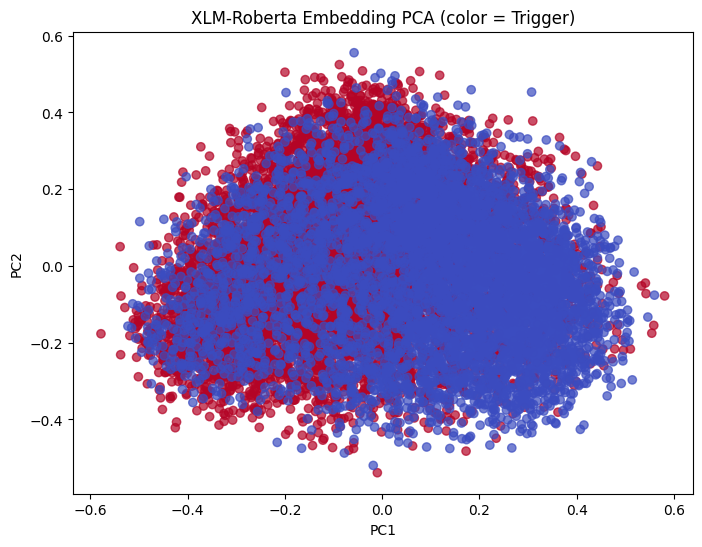

In [99]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], 
            c=df["Trigger"], cmap="coolwarm", alpha=0.7)
plt.title("XLM-Roberta Embedding PCA (color = Trigger)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()